# Time-Varying and Time-Aggregate Sensitivity Analysis with G-VARS

Notebook developed by Saman Razavi and Kasra Keshavarz

### For the VARS method on dynamical model response, please cite:

Razavi, S., & Gupta, H. V. (2019). A multi-method Generalized Global Sensitivity Matrix approach to accounting for the dynamical nature of earth and environmental systems models. Environmental modelling & software, 114, 1-11. https://doi.org/10.1016/j.envsoft.2018.12.002

### For the Generalized VARS (G-VARS) method, please cite:

Do, N. C., & Razavi, S. (2020). Correlation effects? A major but often neglected component in sensitivity and uncertainty analysis. Water Resources Research, 56(3), e2019WR025436. https://doi.org/10.1029/2019WR025436

### For HBV-SASK, please cite:

Razavi, S., Sheikholeslami, R., Gupta, H. V., & Haghnegahdar, A. (2019). VARS-TOOL: A toolbox for comprehensive, efficient, and robust sensitivity and uncertainty analysis. Environmental modelling & software, 112, 95-107. https://www.sciencedirect.com/science/article/pii/S1364815218304766

## Exercise 6: Sensitivity Analysis of HBV-SASK time-series outputs when inputs are non-uniform and correlated 
### Objective:

This notebook extends the previous exercise with the Generalized Global Sensitivity Matrix (GGSM) approach to account for correlated and non-uniformly distributed parameters through the Generalized VARS (G-VARS) method.

First import the needed librares, including `TSGVARS` for time-varying sensitivity analysis and the `Model` class for creating a wrapper around the desired model so that it can be inputted into G-VARS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from varstool import TSGVARS, Model
import hbv

### Introduce the model

Define the function of interest in sensitivity analysis. Here, the following function runs the HBV-SASK model and returns a **time series of model responses**. The output of the model here could be the time series of a flux (e.g., *streamflow*) or state variable (e.g., *soil moisture*) over a given time period. 

In [2]:
def custom_HBV_SASK_2(x):
    param = x.to_dict()
    # running the HBV-SASK Model
    basin = 'Oldman Basin'  # choose the basin of interest, either 'Oldman Basin' or 'Banff Basin'
    flux, state, forcing = hbv.HBV_SASK(basin, param)
    
    start_day ='2005-10-01'  # choose the start date for the period of interest
    end_day   ='2006-09-30'  # choose the end date for the period of interest
    
    # choosing the flux or state variable of interest to report
    out = flux['Q_cms'][start_day:end_day]  # 'Q_cms' (streamflow) is an example flux
#     out = state['SMS'][start_day:end_day]   # 'SMS' (soil moisture storage) is an example state variable

    return out

Wrap the function of interest with the `Model` class.

In [3]:
HBV_model = Model(custom_HBV_SASK_2)

Let's run the wrapped function for an arbitrary input and check the model response.

In [4]:
x=pd.Series({#name  #value
             'TT'   : 0.95 ,
             'C0'   : 0.78 ,
             'ETF'  : 0.12 ,
             'LP'   : 0.67 ,
             'FC'   : 227  ,
             'beta' : 2.70 ,
             'FRAC' : 0.63 ,
             'K1'   : 0.05 ,
             'alpha': 1.60 ,
             'K2'   : 0.02 ,
             'UBAS' : 1.00 ,
             'PM'   : 1.00 ,
             })
HBV_model(x)

2005-10-01    25.514695
2005-10-02    32.584170
2005-10-03    26.992059
2005-10-04    22.398483
2005-10-05    19.194435
                ...    
2006-09-26     3.251775
2006-09-27     3.256444
2006-09-28     3.163086
2006-09-29     3.069727
2006-09-30     2.981379
Name: Q_cms, Length: 365, dtype: float64

### Set up a Time-varying VARS experiment

Create a TSGVARS experiment and set its attributes. Note that G-VARS and TSGVARS share the same attributes.

In [5]:
my_parameters = { # name  dist_par1  dist_par1  dist_par1  dist_type
                 'TT'   : (  0.940  ,  0.980  ,   None   , 'unif'     ),
                 'C0'   : (  0.782  ,  0.003  ,   None   , 'norm'     ),
                 'ETF'  : (  0.126  ,  0.008  ,   None   , 'norm'     ),
                 'LP'   : (  0.670  ,  0.018  ,   None   , 'norm'     ),
                 'FC'   : (  227.53 ,  6.930  ,   None   , 'norm'     ),
                 'beta' : (  2.600  ,  3.000  ,  3.000   , 'triangle' ),
                 'FRAC' : (  0.628  ,  0.011  ,   None   , 'norm'     ),
                 'K1'   : (  0.050  ,  0.054  ,  0.050   , 'triangle' ),
                 'alpha': (  1.602  ,  0.011  ,   None   , 'norm'     ),
                 'K2'   : (  0.022  ,  0.001  ,   None   , 'norm'     ),
                 'UBAS' : (  1.000  ,  1.200  ,  1.000   , 'triangle'  ),
                 'PM'   : (  0.980  ,  1.020  ,   None   , 'unif'     ),}

my_corr_mat = np.array([[    1, 0.65,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
                        [ 0.65,    1,    0,    0,    0,    0,    0,    0,    0, 0.12,    0,    0],
                        [    0,    0,    1, 0.12,-0.18, 0.13,    0,    0,    0,-0.22,    0,    0],
                        [    0,    0, 0.12,    1, 0.54, 0.71,-0.14,    0,    0,    0,    0,    0],
                        [    0,    0,-0.18, 0.54,    1, 0.34, 0.20, 0.11,    0, 0.38,    0,    0],
                        [    0,    0, 0.13, 0.71, 0.34,    1,-0.11,    0,    0,-0.13,    0,    0],
                        [    0,    0,    0,-0.14, 0.20,-0.11,    1,    0,-0.69,-0.39,-0.19,    0],
                        [    0,    0,    0,    0, 0.11,    0,    0,    1,-0.34,    0,    0,    0],
                        [    0,    0,    0,    0,    0,    0,-0.69,-0.34,    1, 0.41, 0.40,    0],
                        [    0, 0.12,-0.22,    0, 0.38,-0.13,-0.39,    0, 0.41,    1, 0.14,    0],
                        [    0,    0,    0,    0,    0,    0,-0.19,    0,  0.4, 0.14,    1,    0],
                        [    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1]])

my_num_dir_samples = 10

my_delta_h = 0.1
# my_delta_h = 1 / my_num_dir_samples # or choose values such as 0.1

experiment_6 = TSGVARS(parameters     = my_parameters,
                    corr_mat        = my_corr_mat,
                    num_stars       = 20,
                    num_dir_samples = my_num_dir_samples,
                    delta_h         = my_delta_h,
                    ivars_scales    = (0.1, 0.3, 0.5),
                    sampler         = 'plhs',
                    slice_size      = 10,
                    model           = HBV_model,
                    seed            = 123456789,
                    bootstrap_flag  = False,
                    bootstrap_size  = 100,
                    bootstrap_ci    = 0.9,
                    grouping_flag   = False,
                    num_grps        = 3,
                    report_verbose  = True,
                    func_eval_method ='serial', # The parallel version needs further development and testing
                    vars_eval_method ='serial', # The parallel version needs further development and testing
                    vars_chunk_size  = None,
                    )

### Run STAR-VARS

Now, run the TSVARS experiment set up above.

In [6]:
experiment_6.run_online()

building fictive matrix:   0%|                                                                  | 0/11 [00:00<…

generating star points
:   0%|                                                                   | 0/8 [00:00<…

function evaluation:   0%|                                                                    | 0/2400 [00:00<…

building pairs:   0%|                                                                          | 0/365 [00:00<…

TSGVARS analysis:   0%|                                                                         | 0/10 [00:00<…

### Check out the results

When the TSGVARS analysis is completed, let's check out the results of **time-varying** and **time-aggregate** sensitivity analysis.

**Time-Varying Sensitivities** 

Similar to `GVARS`, `TSGVARS` generates all the sensitivity indices, including IVARS, VARS-TO (Sobol Total-Order Effect), VARS-ABE and VARS-ACE (Morris Elementary Effect). But unlike `GVARS` that generates sensitivity indices for a single model output, `TSGVARS` does so for the time series of model outputs.

The following cells look at IVARS-50 (Total-Variogram Effect) only, but the user has the option to use other indices as already shown for `VGARS`.
***
For IVARS-50, the result will be a table where each row represents a modelling time step and each column represents a model parameter. This table is called the *Generalized Global Sensitivity Matrix (GGSM)*.

In [17]:
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_6.parameters.keys()
time_varying_SA = experiment_6.ivars.loc[pd.IndexSlice[:, :, ivars_scale]].unstack(level=-1)[cols]
time_varying_SA
time_varying_SA.to_csv('kkk.csv')

Let's plot the time series above for a few select parameters.

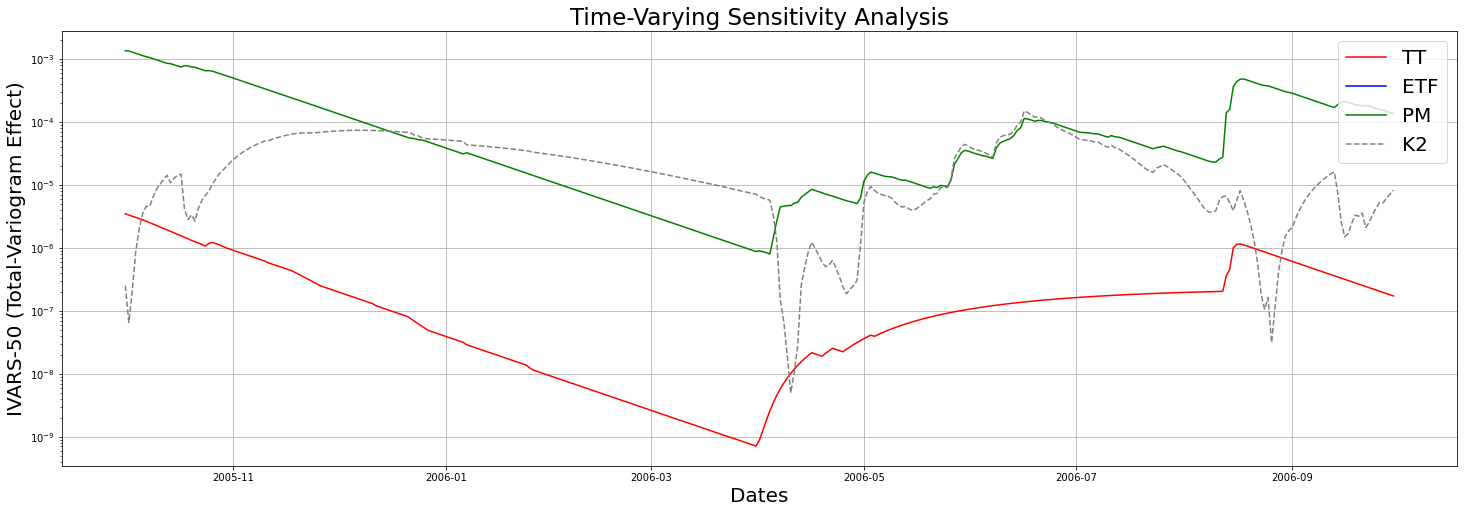

In [8]:
fig = plt.figure(figsize=(25, 8))

plt.gca().plot( time_varying_SA[ 'TT'  ] , '-'  , color='red'   , label=r'TT'  )
plt.gca().plot( time_varying_SA[ 'ETF' ] , '-'  , color='blue'  , label=r'ETF' )
plt.gca().plot( time_varying_SA[ 'PM'  ] , '-'  , color='green' , label=r'PM'  )
plt.gca().plot( time_varying_SA[ 'K2'  ] , '--' , color='grey'  , label=r'K2'  )

plt.gca().set_title(r'Time-Varying Sensitivity Analysis', fontsize = 23)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 20)
plt.gca().set_xlabel('Dates', fontsize=20)
plt.gca().grid()
plt.gca().legend(loc='upper right', fontsize = 20)
plt.gca().set_yscale('log')

**Time-Aggregate Sensitivities** 

The first level of time aggregation in the GGSM approach is through cumulative frequency distributions of the time series of sensitivity index for each individual parameter. The distributions that are more extended to the right correspond to parameters that are more strongly influential.

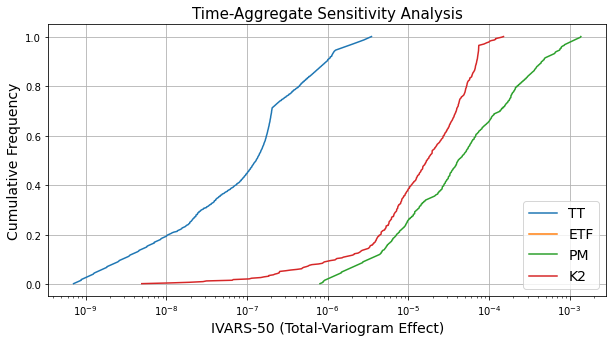

In [9]:
# choose the model parameters of interest for plotting the results
cols = ['TT', 'ETF', 'PM', 'K2']         # choose parameters for plotting
# cols = experiment_2.parameters.keys()  # or plot the results for all parameters

ivars_scale = 0.5                        # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

idx = pd.IndexSlice
time_varying_SA = experiment_6.ivars.loc[idx[:, :, ivars_scale]].unstack(level=-1)[cols]
matrix_x = np.sort(time_varying_SA.values, axis=0)  
column_y = np.linspace( 1, len(matrix_x), len(matrix_x))/len(matrix_x)
matrix_y = np.tile(column_y, (matrix_x.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )

plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'Cumulative Frequency', fontsize = 14)
plt.gca().set_xlabel(r'IVARS-50 (Total-Variogram Effect)', fontsize=14)
plt.gca().legend (cols, loc='lower right', fontsize = 14)
plt.gca().set_xscale('log')
plt.gca().grid()

The second level of aggregation (the most compact form) in the GGSM approach takes the *mean* of the time series of sensitivity index over the simulation time period for each individual parameter. The table below shows the time-aggregate IVARS for all the scale ranges of interest.

In [10]:
cols = experiment_6.parameters.keys()
time_aggregate_SA = experiment_6.ivars.aggregate.unstack(level=0)[cols]
time_aggregate_SA

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
h,,,,,,,,,,,,
0.1,4.136889e-08,0.002140,0.0,0.0,0.0,0.0,0.000727,1.510070e-17,2.197646e-11,0.000003,3.417644e-21,0.000018
0.3,1.938754e-07,0.009619,0.0,0.0,0.0,0.0,0.003897,8.756487e-17,1.087701e-10,0.000016,1.776530e-20,0.000087
0.5,3.254303e-07,0.016716,0.0,0.0,0.0,0.0,0.006841,1.660131e-16,1.897507e-10,0.000028,3.098825e-20,0.000155


Lastly, choose a scale range and plot the respective time-aggregate sensitivity indices for all the parameters in linear and log scales.

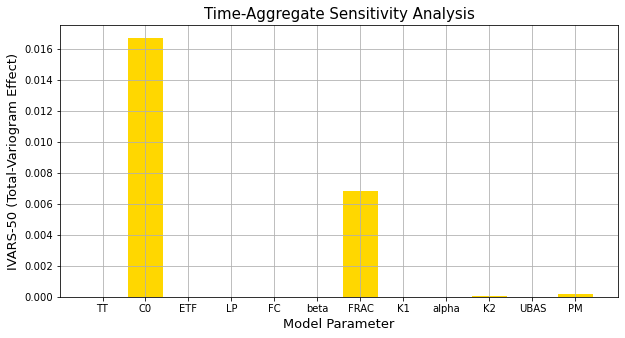

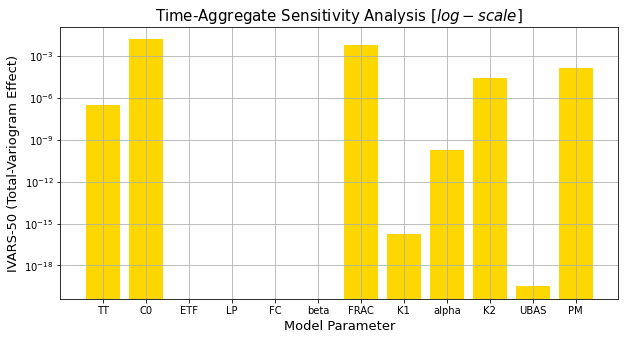

In [11]:
ivars_scale = 0.5   # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_6.parameters.keys()
time_aggregate_SA = experiment_6.ivars.aggregate.unstack(level=0)[cols]

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().grid()

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().grid()

### Further Results: Time Normalization of Sensitivities

When investigating time-aggregate (total-period) and time-varying sensitivity indices as shown above, we have treated each individual time step as being of equal importance. 

However, during some time steps the responses of a model may exhibit more variability (and hence sensitivity) than during other time steps, reflecting the dynamics of the model and (importantly) the strength of its forcings. 

In such cases, the behaviour of the *“more dynamically active”* time steps may, when summarized into a single time-aggregate sensitivity index, obscure the information contained in *“less active time steps”*. For some purposes, therefore, it may be desirable to adjust the weights assigned to different time steps to achieve a more desirable balance.

Below, let's investigate the results after time normalization.
***

Time-Normalized Generalized Global Sensitivity Matrix (GGSM):

In [12]:
ivars_scale = 0.5 # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_6.parameters.keys()
normalized_time_varying_SA = experiment_6.ivars_normalized.loc[pd.IndexSlice[:, :, ivars_scale]].unstack(level=-1)[cols]
normalized_time_varying_SA

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
ts,,,,,,,,,,,,
2005-10-01,0.000018,0.859531,0.0,0.0,0.0,0.0,0.133354,8.810459e-16,1.003914e-09,1.305415e-06,1.167817e-18,0.007095
2005-10-02,0.000018,0.851849,0.0,0.0,0.0,0.0,0.140995,8.947116e-16,1.019617e-09,3.454056e-07,1.140078e-18,0.007138
2005-10-03,0.000017,0.851690,0.0,0.0,0.0,0.0,0.141171,9.298586e-16,1.059688e-09,1.158249e-06,6.486075e-21,0.007121
2005-10-04,0.000017,0.851687,0.0,0.0,0.0,0.0,0.141170,9.712442e-16,1.106853e-09,5.055486e-06,1.823957e-28,0.007121
2005-10-05,0.000017,0.851680,0.0,0.0,0.0,0.0,0.141169,1.014473e-15,1.156118e-09,1.212307e-05,1.858331e-28,0.007120
...,...,...,...,...,...,...,...,...,...,...,...,...
2006-09-26,0.000013,0.576825,0.0,0.0,0.0,0.0,0.412659,1.020567e-14,1.172990e-08,3.393604e-04,1.216806e-27,0.010163
2006-09-27,0.000013,0.567498,0.0,0.0,0.0,0.0,0.421882,1.048547e-14,1.205180e-08,3.432145e-04,6.520077e-19,0.010265
2006-09-28,0.000013,0.566980,0.0,0.0,0.0,0.0,0.422314,1.094201e-14,1.257659e-08,4.244134e-04,1.681113e-21,0.010269


Plot the time series above for a few select parameters (compare this plot with a similar plot above before time normalization).

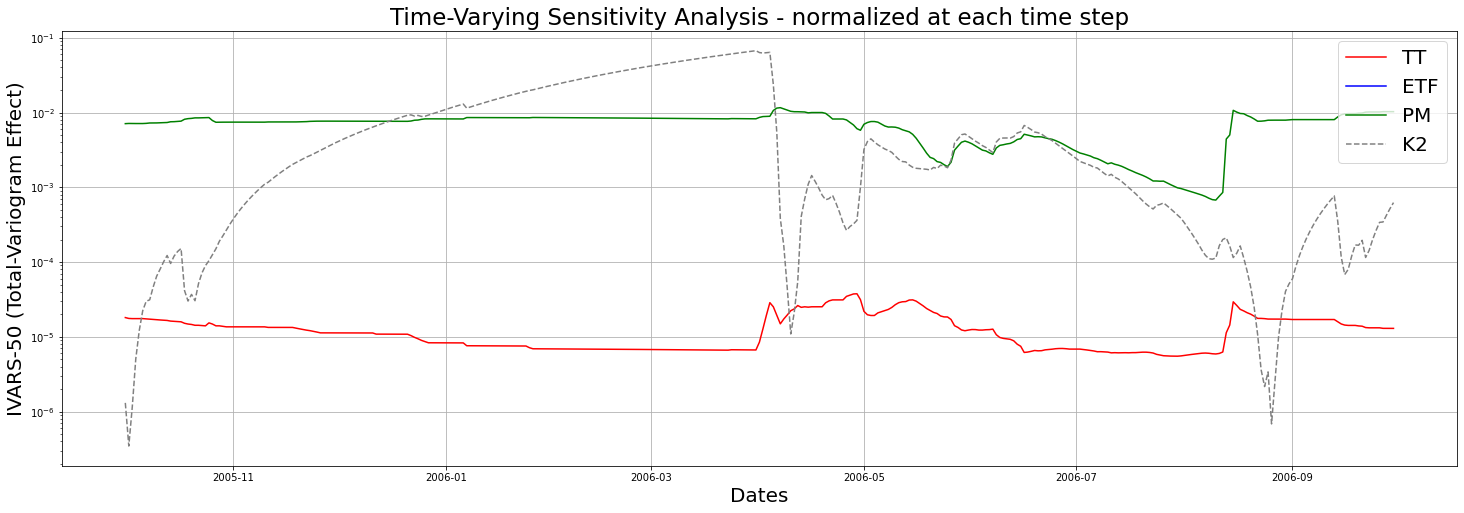

In [13]:
fig = plt.figure(figsize=(25, 8))

plt.gca().plot( normalized_time_varying_SA[ 'TT'  ] , '-'  , color='red'   , label=r'TT'  )
plt.gca().plot( normalized_time_varying_SA[ 'ETF' ] , '-'  , color='blue'  , label=r'ETF' )
plt.gca().plot( normalized_time_varying_SA[ 'PM'  ] , '-'  , color='green' , label=r'PM'  )
plt.gca().plot( normalized_time_varying_SA[ 'K2'  ] , '--' , color='grey'  , label=r'K2'  )

plt.gca().set_title(r'Time-Varying Sensitivity Analysis - normalized at each time step', fontsize = 23)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 20)
plt.gca().set_xlabel('Dates', fontsize=20)
plt.gca().grid()
plt.gca().legend(loc='upper right', fontsize = 20)
plt.gca().set_yscale('log')

**Normalized Time-Aggregate Sensitivities** 

Plor cumulative frequency distributions of the *time-normalized time series of sensitivity index* for each individual parameter. The distributions that are more extended to the right correspond to parameters that are more strongly influential (compare this plot with a similar plot above before time normalization).

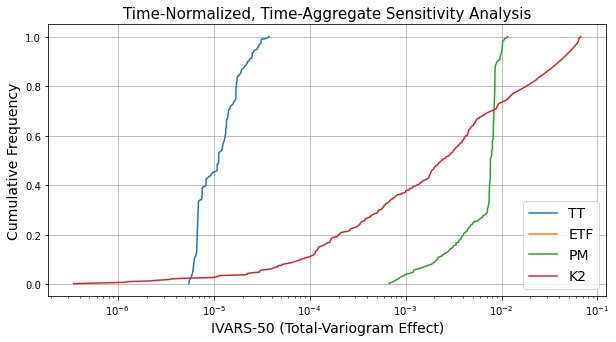

In [14]:
# choose the model parameters of interest for plotting the results
cols = ['TT', 'ETF', 'PM', 'K2']         # choose parameters for plotting
# cols = experiment_2.parameters.keys()  # or plot the results for all parameters

ivars_scale = 0.5                        # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

idx = pd.IndexSlice
normalized_time_varying_SA = experiment_6.ivars_normalized.loc[idx[:, :, ivars_scale]].unstack(level=-1)[cols]
matrix_x = np.sort(normalized_time_varying_SA.values, axis=0)  
column_y = np.linspace( 1, len(matrix_x), len(matrix_x))/len(matrix_x)
matrix_y = np.tile(column_y, (matrix_x.shape[1], 1)).T

fig_cdf = plt.figure(figsize=(10,5))
plt.gca().plot(matrix_x, matrix_y )

plt.gca().set_title (r'Time-Normalized, Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'Cumulative Frequency', fontsize = 14)
plt.gca().set_xlabel(r'IVARS-50 (Total-Variogram Effect)', fontsize=14)
plt.gca().legend (cols, loc='lower right', fontsize = 14)
plt.gca().set_xscale('log')
plt.gca().grid()

The table below shows the time-normalized, time-aggregate IVARS for all the scale ranges of interest.

In [15]:
cols = experiment_6.parameters.keys()
normalized_time_aggregate_SA = experiment_6.ivars_normalized.aggregate.unstack(level=0)[cols]
normalized_time_aggregate_SA

param,TT,C0,ETF,LP,FC,beta,FRAC,K1,alpha,K2,UBAS,PM
h,,,,,,,,,,,,
0.1,0.000013,0.595366,0.0,0.0,0.0,0.0,0.387712,1.178624e-13,1.712437e-07,0.010186,6.585644e-18,0.006722
0.3,0.000013,0.566185,0.0,0.0,0.0,0.0,0.416693,1.404675e-13,1.741899e-07,0.010375,6.616660e-18,0.006734
0.5,0.000013,0.562551,0.0,0.0,0.0,0.0,0.419860,1.515783e-13,1.729609e-07,0.010741,6.601808e-18,0.006835


Lastly, choose a scale range and plot the respective time-normalized, time-aggregate sensitivity indices for all the parameters in linear and log scales.

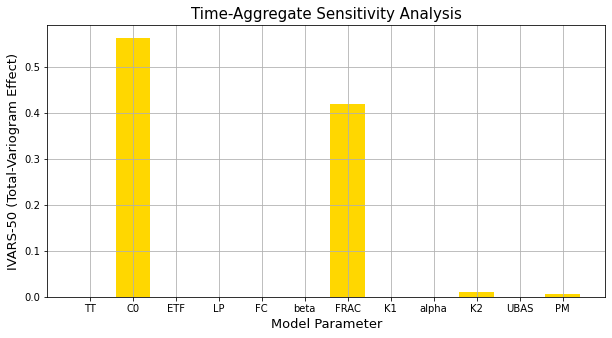

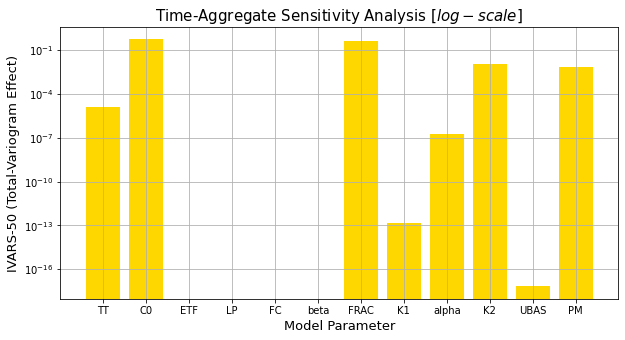

In [16]:
ivars_scale = 0.5   # Choose the scale range of interest, e.g., 0.1, 0.3, or 0.5

cols = experiment_6.parameters.keys()
normalized_time_aggregate_SA = experiment_6.ivars_normalized.aggregate.unstack(level=0)[cols]

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,normalized_time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('linear')
plt.gca().grid()

fig_bar = plt.figure(figsize=(10,5))
plt.gca().bar(cols,normalized_time_aggregate_SA.loc[pd.IndexSlice[ ivars_scale ]], color='gold')
plt.gca().set_title (r'Time-Aggregate Sensitivity Analysis $[log-scale]$', fontsize = 15)
plt.gca().set_ylabel(r'IVARS-50 (Total-Variogram Effect)', fontsize = 13)
plt.gca().set_xlabel(r'Model Parameter', fontsize=13)
plt.gca().set_yscale('log')
plt.gca().grid()

All done!